In [1]:
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
CRS = 'EPSG:4326'

In [3]:
cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(columns={
    'census_block_group': 'cbg',
    'Cluster': 'cluster',
    'Total Population': 'population',
    'Median Household Income': 'income',
})
cbg_df = cbg_df[['cbg', 'cluster', 'population', 'income']]
cbg_df = cbg_df.dropna()
cbg_df['cluster'] = cbg_df['cluster'].astype('category')
cbg_df.head()

,cbg,cluster,population,income
1,360050002001,2,1744,41968.0
2,360050002002,2,1569,48523.0
3,360050002003,3,1219,68060.0
5,360050004002,3,782,60958.0
6,360050004003,0,3425,80185.0


In [4]:
pi_df = pd.read_csv('./exports/proximity_index.csv')
pi_df.head()

,cbg,category_3_proximity_index
0,360050175002,4.363807e+07
1,360050141001,5.243862e+07
2,360050145001,1.903017e+07
3,360050075002,3.807911e+07
4,360050418001,5.460587e+06


In [5]:
cbg_df = cbg_df.merge(pi_df, on='cbg', how='inner')

In [6]:
cluster_df = cbg_df.groupby(by=['cluster']).agg({'category_3_proximity_index': 'mean'}).reset_index()
cluster_df.head()

,cluster,category_3_proximity_index
0,0,2.465165e+07
1,1,5.937936e+07
2,2,2.988581e+07
3,3,2.733446e+07


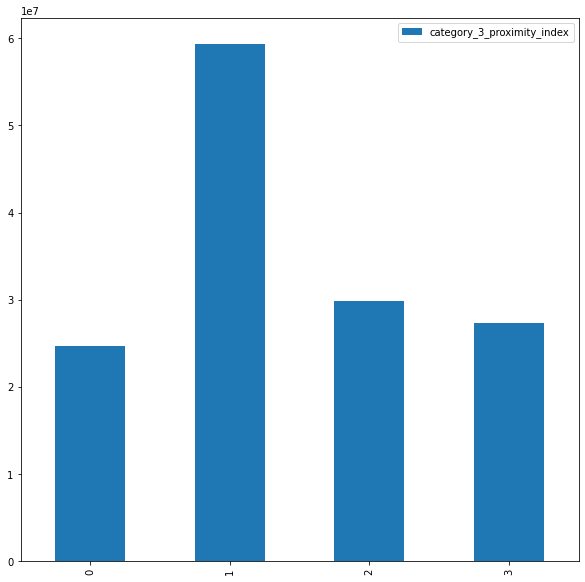

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
cluster_df.plot.bar(ax=ax)
plt.show()

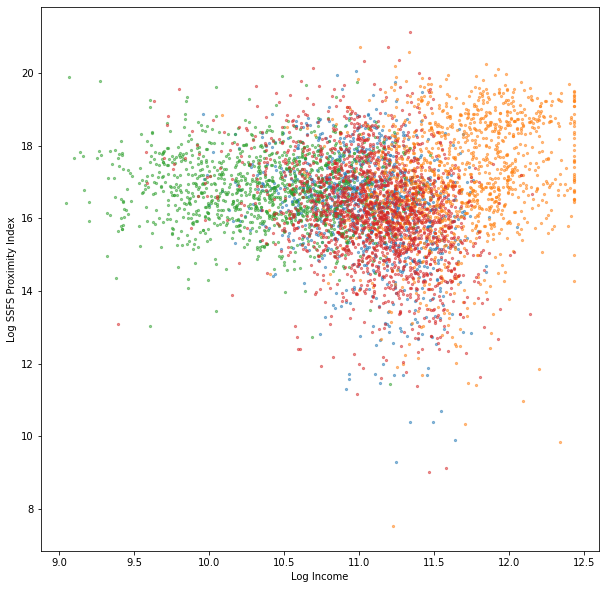

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(0, 4):
    df = cbg_df[cbg_df['cluster'] == i]
    x = np.log(df['income'])
    y = np.log(df['category_3_proximity_index'])
    ax.scatter(np.log(df['income']), np.log(df['category_3_proximity_index']), c=f'C{i}', alpha=0.5, s=5)
ax.set_xlabel('Log Income')
ax.set_ylabel('Log SSFS Proximity Index')
plt.show()

In [9]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')
    
home_df = pd.read_csv('./exports/home_weekly.csv')
repair_dates(home_df)
home_df = home_df[home_df['date_range_start'].dt.year.isin([2019, 2020])]
home_df = home_df.rename(columns={'home_cbg': 'cbg'})
home_df.head()

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
95,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360050001000,4,0.000000,0.333333,0.000000,0.000000
96,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470206001,4,9.790000,0.021739,0.021739,2.772665
97,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470435003,4,8.605042,0.016129,0.016129,2.437068
98,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470437001,4,11.749526,0.024390,0.024390,3.327630
99,22t-222@627-s7m-rtv,2019-01-07 00:00:00-05:00,360470573002,5,1.068101,0.005160,0.005160,0.302501


In [10]:
poi_df = pd.read_csv('./exports/poi.csv')
poi_df = poi_df[['placekey', 'category']]
poi_df.head()

,placekey,category
0,226-222@627-s4n-pqf,Supermarkets and Specialty Food Stores
1,225-225@627-s99-9xq,Supermarkets and Specialty Food Stores
2,225-225@627-vsw-7nq,Supermarkets and Specialty Food Stores
3,22b-222@627-s7s-jqf,Supermarkets and Specialty Food Stores
4,23h-222@627-s9z-n3q,Supermarkets and Specialty Food Stores


In [11]:
categories = list(set(poi_df['category']))
categories.sort()
display(categories)

INDEX_SSFS = 4
cdi_cbg_weekly_df = home_df[home_df['date_range_start'].dt.year == 2020]
cdi_cbg_weekly_df = cdi_cbg_weekly_df.merge(poi_df, on='placekey', how='left')
cdi_cbg_weekly_df = cdi_cbg_weekly_df[cdi_cbg_weekly_df['category'] == categories[INDEX_SSFS]]
cdi_cbg_weekly_df.head()

['Community and Special Food Services',
 'Food (Health) Supplement Stores',
 'General Merchandise and Convenience Stores',
 'Restaurants and Other Eating Places',
 'Supermarkets and Specialty Food Stores',
 'Tobacco and Liquor Stores']

,placekey,date_range_start,cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,category
0,23h-222@627-s8w-kvf,2020-01-06 00:00:00-05:00,360050001001,4,269.176471,0.061538,0.061538,8.568337,Supermarkets and Specialty Food Stores
1,23h-222@627-s8w-kvf,2020-01-06 00:00:00-05:00,360470114001,4,33.547325,0.076923,0.076923,1.067867,Supermarkets and Specialty Food Stores
2,23h-222@627-s8w-kvf,2020-01-06 00:00:00-05:00,360470271001,4,12.266244,0.010582,0.010582,0.390455,Supermarkets and Specialty Food Stores
3,23h-222@627-s8w-kvf,2020-01-06 00:00:00-05:00,360470722001,5,17.975113,0.017730,0.017730,0.572178,Supermarkets and Specialty Food Stores
4,23h-222@627-s8w-kvf,2020-01-06 00:00:00-05:00,360470882001,4,15.321839,0.008475,0.008475,0.487720,Supermarkets and Specialty Food Stores


In [12]:
cdi_cbg_df = cdi_cbg_weekly_df.groupby(by=['cbg']).agg({'cdi': 'median'}).reset_index()

In [13]:
cdi_cbg_df

,cbg,cdi
0,360050001001,4.211850
1,360050002001,0.273660
2,360050002002,0.122550
3,360050002003,0.100032
4,360050004000,0.000000
...,...,...
6331,360850319021,0.151616
6332,360850319022,0.105426
6333,360850319023,0.113643
6334,360850323001,0.080427


In [14]:
cbg_df = cbg_df.merge(cdi_cbg_df, on='cbg', how='inner')

In [15]:
cbg_df['cdi_per_capita'] = cbg_df['cdi'] / cbg_df['population']

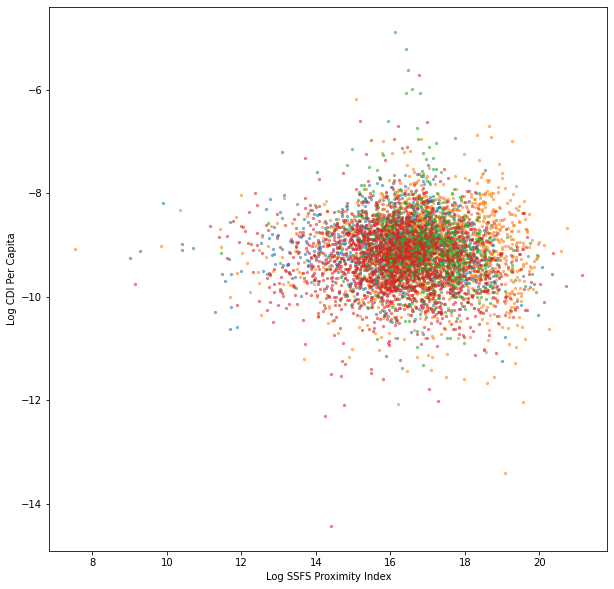

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(0, 4):
    df = cbg_df[cbg_df['cluster'] == i]
    x = np.log(df['category_3_proximity_index'])
    y = np.log(df['cdi_per_capita'])
    ax.scatter(x, y, c=f'C{i}', alpha=0.5, s=5)
ax.set_xlabel('Log SSFS Proximity Index')
ax.set_ylabel('Log CDI Per Capita')
plt.show()